<div align="center">

# <span style="color: #3498db;">CA2 - Genetic and Games Algorithm</span>

**<span style="color:rgb(247, 169, 0);">[Shayan Maleki]</span> - <span style="color:rgb(143, 95, 195);">[810102515]</span>**

</div>

# <span style="color: #3498db;">Genetic Algorithm</span>

## Imports

In [3]:
from bisect import bisect_left
from dataclasses import dataclass
from itertools import accumulate
from random import randrange, random, uniform
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
from tqdm import tqdm

In [4]:
class ImageAnalysis:
    def __init__(self, image: Image, rows: int, columns: int):
        self._image = image
        self._rows = rows
        self._columns = columns
        self._pieces = self._split_image()
        self._dissimilarity_matrix = self._calculate_dissimilarity_matrix()

    @property
    def pieces(self) -> dict:
        return self._pieces

    def get_dissimilarity(self, ids: tuple, orientation: str) -> float:
        return self._dissimilarity_matrix[ids][orientation]

    def _split_image(self) -> dict:
        width, height = self._image.size
        piece_width = width // self._columns
        piece_height = height // self._rows

        pieces = {}
        for i in range(self._rows):
            for j in range(self._columns):
                left = j * piece_width
                top = i * piece_height
                right = left + piece_width
                bottom = top + piece_height
                piece = self._image.crop((left, top, right, bottom))
                pieces[i * self._columns + j] = piece
        return pieces

    def _calculate_dissimilarity_matrix(self) -> dict:
        matrix = {}
        for i in range(self._rows * self._columns):
            for j in range(self._rows * self._columns):
                if i == j:
                    continue
                matrix[i, j] = {
                    "L-R": self._dissimilarity_measure(self._pieces[i], self._pieces[j], "L-R"),
                    "T-D": self._dissimilarity_measure(self._pieces[i], self._pieces[j], "T-D"),
                }
        return matrix

    def _dissimilarity_measure(self,piece1: Image, piece2: Image, orientation: str) -> float:
        piece1_array = np.asarray(piece1)
        piece2_array = np.asarray(piece2)
    
        if orientation == "L-R":
            edge1 = piece1_array[:, -1, :]
            edge2 = piece2_array[:, 0, :]
        elif orientation == "T-D":
            edge1 = piece1_array[-1, :, :]
            edge2 = piece2_array[0, :, :]
    
        diff_r = np.sum((edge1[:, 0] - edge2[:, 0]) ** 2)
        diff_g = np.sum((edge1[:, 1] - edge2[:, 1]) ** 2)
        diff_b = np.sum((edge1[:, 2] - edge2[:, 2]) ** 2)
    
        total_diff = (diff_r + diff_g + diff_b) / 3
        return total_diff


## Image Analysis

### ImageAnalysis Class

The `ImageAnalysis` class is responsible for two main tasks:

1.  **Splitting the Image**: It takes the source image and splits it into a grid of smaller puzzle pieces.
2.  **Calculating Dissimilarity**: It computes a "dissimilarity matrix," which stores a score of how well any two pieces fit together. This is crucial for the genetic algorithm's fitness function.

You will need to implement the `_dissimilarity_measure` method, which is the core of the analysis. The rest of the class is provided for you.

### Task: Implement the `dissimilarity_measure` Method

The `dissimilarity_measure` method calculates how different two puzzle pieces are when placed next to each other. This is a key part of the fitness function, as it determines how well pieces fit together.

#### What You Need to Do:

-   **Implement the `_dissimilarity_measure` method** in the `ImageAnalysis` class.
-   The method should take two `PIL.Image` objects (`piece1`, `piece2`) and an `orientation` string (`"L-R"` for left-right or `"T-D"` for top-down).
-   It should return a single `float` value representing the dissimilarity.

#### Hints:

1.  **Convert Images to NumPy Arrays**: Use `np.asarray(piece)` to convert the `PIL.Image` objects into NumPy arrays. This makes it easier to perform mathematical operations on the pixel data.

2.  **Extract Edges**: Depending on the `orientation`, you need to extract the pixels from the touching edges of the two pieces.
    -   For `"L-R"` (Left-Right), you need the **right edge of `piece1`** and the **left edge of `piece2`**.
    -   For `"T-D"` (Top-Down), you need the **bottom edge of `piece1`** and the **top edge of `piece2`**.

3.  **Calculate Dissimilarity**: The dissimilarity can be calculated as the **sum of squared differences** between the pixel values of the two edges. The formula is:

    ```
    dissimilarity = sum((edge1 - edge2)^2)
    ```

    You can use `np.sum()` and basic arithmetic operations on the NumPy arrays to compute this value.

## Size Detector

In [5]:
class SizeDetector:
    def __init__(self, image: Image):
        self._image = image

    def detect(self) -> tuple:
        width, height = self._image.size
        aspect_ratio = width / height

        for i in range(1, int(width**0.5) + 1):
            if width % i == 0:
                j = width // i
                if abs(j / i - aspect_ratio) < 0.1:  # Heuristic for aspect ratio
                    return (i, j) if width > height else (j, i)
        return (1, width) # Fallback

## Size Detector

### SizeDetector Class

The `SizeDetector` class automatically determines the size of the puzzle pieces from the input image. It works by analyzing the image's properties and looking for repeating patterns that suggest the dimensions of the pieces.

This class is provided to you and does not require any modifications. You can use it to get the piece size before starting the genetic algorithm.

## Individual

### Task: Implement the `Individual` Class

The `Individual` class represents a possible solution to the jigsaw puzzle. It stores the puzzle pieces and evaluates how well they fit together. You will need to implement several parts of this class to calculate the fitness and manage the puzzle pieces.

#### 1. Fitness Calculation (`fitness` property)

- **What You Need to Do**:
  - Implement the `fitness` property to calculate how well the pieces fit together.
  - The fitness value should be based on how the pieces align (i.e., their edges) both horizontally and vertically.
  - The fitness function should return an inverse fitness value based on the dissimilarities between adjacent pieces.

  **Hint**:
  - Use the `ImageAnalysis.get_dissimilarity(ids, orientation)` function to get the dissimilarity between adjacent pieces.
  - Calculate the dissimilarity between adjacent pieces both **horizontally** and **vertically** (Left-Right and Top-Down).

#### 2. Core Methods (`__init__`, `piece_size`, `piece_by_id`)

- **What You Need to Do**:
  - Implement the `__init__` method to initialize the puzzle with pieces and store the number of rows and columns.
  - Implement the `piece_size()` method to return the size of a single piece.
  - Implement the `piece_by_id()` method to retrieve a piece by its unique ID.

---

#### Parts You **Do Not Need to Implement**:

- **`edge` Method**:
  - This method checks the neighboring piece's ID based on orientation (top, right, bottom, left). It is useful for advanced puzzle assembly but is **not necessary** for this task. You can **skip** implementing this method.

- **`to_image` Method**:
  - This method reassembles the individual puzzle into a complete image. It is used for **visualization** of the solution and is **not required** for fitness evaluation. You can **skip** implementing this method.

In [6]:
class Individual:
    def __init__(self, pieces: dict, rows: int, columns: int, initial_state: List[int] = None):

        self._pieces = pieces
        self._rows = rows
        self._columns = columns
        self._fitness = None
        piece_ids = list(self._pieces.keys())

        if initial_state is None:
            shuffled_ids = np.random.permutation(piece_ids)
            self._chromosome = shuffled_ids.reshape((self._rows, self._columns))
        else:

            self._chromosome = np.array(initial_state).reshape((self._rows, self._columns))

    @property
    def fitness(self) -> float:
        if self._fitness is not None:
            return self._fitness

        reconstructed_image = self.to_image()
        temp_analyzer = ImageAnalysis(image=reconstructed_image, rows=self._rows, columns=self._columns)
        total_dissimilarity = 0.0

        for r in range(self._rows):
            for c in range(self._columns):
                current_piece_id = self._chromosome[r, c]

                if c < self._columns - 1:
                    right_piece_id = self._chromosome[r, c + 1]
                    dissimilarity = temp_analyzer.get_dissimilarity(
                        ids=(current_piece_id, right_piece_id), 
                        orientation='L-R'
                    )
                    total_dissimilarity += dissimilarity

                if r < self._rows - 1:
                    bottom_piece_id = self._chromosome[r + 1, c]
                    dissimilarity = temp_analyzer.get_dissimilarity(
                        ids=(current_piece_id, bottom_piece_id), 
                        orientation='T-D'
                    )
                    total_dissimilarity += dissimilarity
        
        if total_dissimilarity == 0:
            self._fitness = float('inf')
        else:
            self._fitness = 1 / total_dissimilarity
            
        return self._fitness


    def piece_size(self) -> tuple:
        any_piece = self._pieces[0]
        img = any_piece.image if hasattr(any_piece, "image") else any_piece
        return img.size

    def piece_by_id(self, piece_id: int) -> Image:
        piece = self._pieces[piece_id]
        return piece.image if hasattr(piece, "image") else piece



    def to_image(self) -> Image:
        """Reassembles the individual into a single image."""
        piece_width, piece_height = self.piece_size()
        canvas_width = self._columns * piece_width
        canvas_height = self._rows * piece_height
        canvas = Image.new('RGB', (canvas_width, canvas_height))

        for i in range(self._rows):
            for j in range(self._columns):
                piece_id = self._chromosome[i, j]
                piece = self.piece_by_id(piece_id)
                canvas.paste(piece, (j * piece_width, i * piece_height))
        return canvas

    def __getitem__(self, key):
        return self._chromosome[key]

    def __repr__(self):
        return f"Individual(fitness={self.fitness})"

## Selection

### Task: Implement the `roulette_selection` Function

The **roulette selection** process is part of the genetic algorithm and is used to select pairs of individuals from the population based on their **fitness**. The fitter individuals are more likely to be selected for reproduction, but all individuals still have a chance of being selected, even if their fitness is low.

---

#### **Hints**:

- You can use `random.uniform(0, total_sum)` to generate a random number between 0 and the total fitness sum.
- The `bisect_left` function helps find the position in the probability intervals where the random number fits.
- The **elites** are guaranteed to move to the next generation without crossover, so they should be excluded from the random selection process.

---

### Task: Implement Another Selection Method

Besides `roulette_selection`, there are other selection strategies. Implement one of the following:

1.  **Tournament Selection**:
    -   Randomly select a few individuals (a "tournament").
    -   The individual with the best fitness in the tournament is chosen as a parent.
    -   Repeat to select the second parent.

2.  **Rank Selection**:
    -   Rank the individuals by fitness.
    -   Selection probability is based on rank, not fitness value. This can prevent premature convergence.

In [7]:
def roulette_selection(population: List[Individual], elite_size: int) -> List[Tuple[Individual, Individual]]:
    """TODO: Implement roulette wheel selection to choose pairs of parents."""
    population.sort(key=lambda ind: ind.fitness, reverse=True)

    selection_pool = population[elite_size:]
    
    if len(selection_pool) < 2:
        return []

    fitness_values = [ind.fitness for ind in selection_pool]
    total_fitness = sum(fitness_values)

    if total_fitness == 0:
        probabilities = [1 / len(selection_pool)] * len(selection_pool)
    else:
        probabilities = [f / total_fitness for f in fitness_values]

    parent_pairs = []
    num_pairs_needed = (len(population) - elite_size) 

    for _ in range(num_pairs_needed):
        parents_for_this_pair = []
        for i in range(2):
            pick = random.random() 
            current_prob_sum = 0
            for j in range(len(selection_pool)):
                current_prob_sum += probabilities[j]
                if pick < current_prob_sum:
                    parents_for_this_pair.append(selection_pool[j])
                    break
        
        parent_pairs.append(tuple(parents_for_this_pair))


    return parent_pairs


def k_best_selection(population: List[Individual], elite_size: int, k: int) -> List[Tuple[Individual, Individual]]:
    population.sort(key=lambda ind: ind.fitness, reverse=True)
    
    selection_pool = population[elite_size:]
    
    if len(selection_pool) < k:
        return [] 

    parent_pairs = []
    num_pairs_needed = (len(population) - elite_size) 
    
    for _ in range(num_pairs_needed):
        parents_for_this_pair = []
        for _ in range(2):
            competitors = random.sample(selection_pool, k)
            winner = max(competitors, key=lambda ind: ind.fitness)
            parents_for_this_pair.append(winner)
        
        parent_pairs.append(tuple(parents_for_this_pair))
            
    return parent_pairs


## Crossover

### Task: Implement the Crossover Logic

Crossover is where the "genetic" part of the algorithm happens. You'll create a new "child" individual by combining the traits of two "parent" individuals. The goal is to build a better-assembled puzzle by picking the best-fitting pieces from the parents.

This crossover strategy is complex. It starts with a random piece and then iteratively adds adjacent pieces based on a priority system.

#### Crossover Priority System:

1.  **Shared Pieces (Highest Priority)**: If two parents agree on a neighboring piece, that piece is chosen. This is a strong indicator of a correct fit.
2.  **Buddy Pieces (Medium Priority)**: A "buddy piece" is a pair of pieces that are each other's best match. If one of these is a neighbor, it's a good candidate.
3.  **Best Match (Lowest Priority)**: If neither of the above is found, choose the piece that has the lowest dissimilarity score (the best fit) from the remaining pieces.

---

#### Your Tasks:

1.  **Implement Piece Selection Methods**:
    -   `_get_shared_piece()`: Find pieces that are neighbors in **both** parents.
    -   `_get_buddy_piece()`: Find "buddy" pieces (mutual best friends).
    -   `_get_best_match_piece()`: Find the piece with the best dissimilarity score among the available pieces.

2.  **Implement the `Crossover` Class**:
    -   Use a `heapq` (min-heap) to manage candidate pieces based on the priority system.
    -   Implement the `run()` method to build the child's chromosome by selecting from the candidates.
    -   You can create different versions of the `add_piece_candidate` method to experiment with different strategies (e.g., one using only shared and best-match pieces, and another using all three).

3.  **Experiment and Compare**:
    -   After implementing the `Crossover` class, you can create variations of it. For example, one version might only use "shared" and "best match" pieces, while another could use all three priorities.
    -   Compare how these different crossover strategies affect the speed and quality of the solution. Does including "buddy pieces" help? Is it worth the extra computation?


In [8]:
import heapq

SHARED_PIECE_PRIORITY = -10
BUDDY_PIECE_PRIORITY = -1

def complementary_orientation(orientation):
    return {"T": "D", "R": "L", "D": "T", "L": "R"}.get(orientation)

class Crossover:
    def __init__(self, parent1: Individual, parent2: Individual, analysis: ImageAnalysis):
        self._parents = (parent1, parent2)
        self._analysis = analysis
        self._pieces_length = len(parent1._pieces)
        self._child_rows = parent1._rows
        self._child_columns = parent1._columns
        self._kernel = {}
        self._taken_positions = set()
        self._candidate_pieces = []
        self._min_row, self._max_row, self._min_column, self._max_column = 0, 0, 0, 0

    def run(self):
        # TODO: Implement the main crossover loop.
        # This should initialize the kernel and then process candidate pieces
        # until the child chromosome is full.
        

        self._initialize_kernel()

        while not self._is_kernel_full():
            if not self._candidate_pieces:
                break

            # Pop the best candidate piece from the heap.

            _priority, (position, piece_id), _relative_piece = heapq.heappop(self._candidate_pieces)
            

            if piece_id in self._kernel:
                continue


            self._put_piece_to_kernel(piece_id, position)



#### faulty child methode :

    # def child(self) -> Individual:
    #     # This method is provided for you. It assembles the new child individual.
    #     pieces = [None] * self._pieces_length
    #     for piece_id, (row, column) in self._kernel.items():
    #         index = (row - self._min_row) * self._child_columns + (column - self._min_column)
    #         pieces[index] = self._parents[0].piece_by_id(piece_id)
        
    #     # Fill any remaining empty spots with unused pieces
    #     used_piece_ids = {p.id for p in pieces if p is not None}
    #     all_pieces = {p.id: p for p in self._parents[0]._pieces.values()}
    #     unused_pieces = [all_pieces[pid] for pid in all_pieces if pid not in used_piece_ids]
        
    #     for i in range(self._pieces_length):
    #         if pieces[i] is None:
    #             pieces[i] = unused_pieces.pop()

    #     return Individual(dict(zip([p.id for p in pieces], pieces)), self._child_rows, self._child_columns)
    
    
    
    
    
    
    
    def child(self) -> Individual:
        """Assemble a full chromosome from the kernel; no None entries are allowed."""
        child_chromosome_list = [None] * self._pieces_length

        # Place every kernel piece in its translated slot
        for piece_id, (row, column) in self._kernel.items():
            index = (row - self._min_row) * self._child_columns + (column - self._min_column)
            child_chromosome_list[index] = piece_id

        # Work out which IDs are still unused
        used_piece_ids = {pid for pid in child_chromosome_list if pid is not None}
        all_piece_ids = list(self._parents[0]._pieces.keys())
        unused_piece_ids = [pid for pid in all_piece_ids if pid not in used_piece_ids]

        # Fill any remaining holes and fail loudly if we somehow run out
        for idx, gene in enumerate(child_chromosome_list):
            if gene is None:
                if not unused_piece_ids:
                    raise RuntimeError("Crossover child assembly ran out of piece IDs.")
                child_chromosome_list[idx] = unused_piece_ids.pop()

        # Final sanity check guarantees downstream code never sees None
        if any(gene is None for gene in child_chromosome_list):
            raise RuntimeError("Crossover child assembly produced an incomplete chromosome.")

        return Individual(
            pieces=self._parents[0]._pieces,
            rows=self._child_rows,
            columns=self._child_columns,
            initial_state=child_chromosome_list,
        )
  

    def _initialize_kernel(self):
        # This method is provided. It selects a random starting piece.
        root_piece_id = list(self._parents[0]._pieces.keys())[randrange(self._pieces_length)]
        self._put_piece_to_kernel(root_piece_id, (0, 0))

    def _put_piece_to_kernel(self, piece_id: int, position: tuple):
        # This method is provided. It adds a piece to the solution kernel.
        self._kernel[piece_id] = position
        self._taken_positions.add(position)
        self._update_candidate_pieces(piece_id, position)

    def _update_candidate_pieces(self, piece_id: int, position: tuple):
        # This method is provided. It finds available boundaries and adds new candidates.
        for orientation, pos in self._available_boundaries(position):
            self.add_piece_candidate(piece_id, orientation, pos)
    def add_piece_candidate(self, piece_id: int, orientation: str, position: tuple):
        """
        TODO: Implement the logic to add candidate pieces to the heap.
        This is where you will use your _get_shared_piece, _get_buddy_piece,
        and _get_best_match_piece methods to decide which piece to add.
        Remember to use the priority constants!
        """
        relative_piece_info = (piece_id, self._kernel[piece_id])

        # Priority 1: Check for a shared piece (highest priority).
        shared_id = self._get_shared_piece(piece_id, orientation)
        if self._is_valid_piece(shared_id):
            self._add_candidate_to_heap(SHARED_PIECE_PRIORITY, shared_id, position, relative_piece_info)
            return

        # Priority 2: Check for a buddy piece (medium priority).
        buddy_id = self._get_buddy_piece(piece_id, orientation)
        if self._is_valid_piece(buddy_id):
            self._add_candidate_to_heap(BUDDY_PIECE_PRIORITY, buddy_id, position, relative_piece_info)
            # If we find a buddy piece, we also stop here.
            return

        # Priority 3: Find the best match from the remaining pieces (lowest priority).
        best_match_id, dissimilarity = self._get_best_match_piece(piece_id, orientation)
        if self._is_valid_piece(best_match_id):
            self._add_candidate_to_heap(dissimilarity, best_match_id, position, relative_piece_info)

    def _get_shared_piece(self, piece_id: int, orientation: str):
        parent1 = self._parents[0]
        parent2 = self._parents[1]
        
        neighbor1_id = None
        neighbor2_id = None

        coords1 = np.where(parent1._chromosome == piece_id)
        coords2 = np.where(parent2._chromosome == piece_id)

        if coords1[0].size == 0 or coords2[0].size == 0:
            return None

        row1, col1 = coords1[0][0], coords1[1][0]
        row2, col2 = coords2[0][0], coords2[1][0]

        if orientation == "T":
            if row1 > 0:
                neighbor1_id = parent1._chromosome[row1 - 1, col1]
            if row2 > 0:
                neighbor2_id = parent2._chromosome[row2 - 1, col2]
        
        elif orientation == "R":
            if col1 < parent1._columns - 1:
                neighbor1_id = parent1._chromosome[row1, col1 + 1]
            if col2 < parent2._columns - 1:
                neighbor2_id = parent2._chromosome[row2, col2 + 1]

        elif orientation == "D":
            if row1 < parent1._rows - 1:
                neighbor1_id = parent1._chromosome[row1 + 1, col1]
            if row2 < parent2._rows - 1:
                neighbor2_id = parent2._chromosome[row2 + 1, col2]

        elif orientation == "L":
            if col1 > 0:
                neighbor1_id = parent1._chromosome[row1, col1 - 1]
            if col2 > 0:
                neighbor2_id = parent2._chromosome[row2, col2 - 1]

        if neighbor1_id != None and neighbor1_id == neighbor2_id:
            return neighbor1_id
        
        return None

    def _get_buddy_piece(self, piece_id: int, orientation: str) :
        piece_A_id = piece_id
        
        # Get all pieces that are not yet placed in the child's kernel
        available_piece_ids = set(self._parents[0]._pieces.keys()) - set(self._kernel.keys())

        # --- Step 1: Find B, the best match for A, from available pieces ---
        best_match_for_A = None
        min_dissimilarity_A = math.inf

        for candidate_id in available_piece_ids:
            if candidate_id == piece_A_id:
                continue

            # Determine the correct key and pair order for the dissimilarity matrix
            if orientation == "R":
                dissim = self._analysis.get_dissimilarity((piece_A_id, candidate_id), "L-R")
            elif orientation == "L":
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_A_id), "L-R")
            elif orientation == "D":
                dissim = self._analysis.get_dissimilarity((piece_A_id, candidate_id), "T-D")
            else:  # orientation == "T"
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_A_id), "T-D")
            
            if dissim < min_dissimilarity_A:
                min_dissimilarity_A = dissim
                best_match_for_A = candidate_id
        
        if best_match_for_A is None:
            return None
        
        piece_B_id = best_match_for_A

        # --- Step 2: Now, check if A is the best match for B ---
        comp_orientation = complementary_orientation(orientation)
        best_match_for_B = None
        min_dissimilarity_B = math.inf

        # The pool of candidates for B's neighbor includes A, but not B itself.
        candidates_for_B = (available_piece_ids | {piece_A_id}) - {piece_B_id}

        for candidate_id in candidates_for_B:
            if comp_orientation == "R":
                dissim = self._analysis.get_dissimilarity((piece_B_id, candidate_id), "L-R")
            elif comp_orientation == "L":
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_B_id), "L-R")
            elif comp_orientation == "D":
                dissim = self._analysis.get_dissimilarity((piece_B_id, candidate_id), "T-D")
            else:  # comp_orientation == "T"
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_B_id), "T-D")
            
            if dissim < min_dissimilarity_B:
                min_dissimilarity_B = dissim
                best_match_for_B = candidate_id

        # --- Step 3: Final validation ---
        if best_match_for_B == piece_A_id:
            return piece_B_id
        
        return None

    def _get_best_match_piece(self, piece_id: int, orientation: str) -> Tuple[int, float]:
        available_piece_ids = set(self._parents[0]._pieces.keys()) - set(self._kernel.keys())

        if not available_piece_ids:
            return None, math.inf

        best_match_id = None
        min_dissimilarity = math.inf

        for candidate_id in available_piece_ids:
            if orientation == "R":
                dissim = self._analysis.get_dissimilarity((piece_id, candidate_id), "L-R")
            elif orientation == "L":
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_id), "L-R")
            elif orientation == "D":
                dissim = self._analysis.get_dissimilarity((piece_id, candidate_id), "T-D")
            else:  # orientation == "T"
                dissim = self._analysis.get_dissimilarity((candidate_id, piece_id), "T-D")
            
            if dissim < min_dissimilarity:
                min_dissimilarity = dissim
                best_match_id = candidate_id
        
        return best_match_id, min_dissimilarity
    def _add_candidate_to_heap(self, priority: int, piece_id: int, position: tuple, relative_piece: tuple):
        # This is a helper to push candidates to the heap.
        heapq.heappush(self._candidate_pieces, (priority, (position, piece_id), relative_piece))

    # The following helper methods for boundary checks are provided for you.
    def _available_boundaries(self, row_and_column):
        (row, column) = row_and_column
        boundaries = []
        if not self._is_kernel_full():
            positions = {"T": (row - 1, column), "R": (row, column + 1), "D": (row + 1, column), "L": (row, column - 1)}
            for orientation, position in positions.items():
                if position not in self._taken_positions and self._is_in_range(position):
                    self._update_kernel_boundaries(position)
                    boundaries.append((orientation, position))
        return boundaries

    def _is_kernel_full(self):
        return len(self._kernel) == self._pieces_length

    def _is_in_range(self, pos):
        return self._is_row_in_range(pos[0]) and self._is_column_in_range(pos[1])

    def _is_row_in_range(self, row):
        return abs(min(self._min_row, row)) + abs(max(self._max_row, row)) < self._child_rows

    def _is_column_in_range(self, col):
        return abs(min(self._min_column, col)) + abs(max(self._max_column, col)) < self._child_columns

    def _update_kernel_boundaries(self, pos):
        self._min_row, self._max_row = min(self._min_row, pos[0]), max(self._max_row, pos[0])
        self._min_column, self._max_column = min(self._min_column, pos[1]), max(self._max_column, pos[1])

    def _is_valid_piece(self, piece_id):
        return piece_id is not None and piece_id not in self._kernel


## Mutation

In [9]:
import random
import numpy as np
from copy import deepcopy

def mutation(individual: Individual, mutation_rate: float = 0.01) -> Individual:
    """
    Applies swap mutation to an individual based on the mutation rate.
    A new individual is returned, the original is not modified.
    """

    mutated_chromosome = deepcopy(individual._chromosome)

    if random.random() < mutation_rate:
        rows, cols = individual._rows, individual._columns
        
        p1_row, p1_col = random.randint(0, rows - 1), random.randint(0, cols - 1)
        p2_row, p2_col = random.randint(0, rows - 1), random.randint(0, cols - 1)

        while (p1_row, p1_col) == (p2_row, p2_col):
            p2_row, p2_col = random.randint(0, rows - 1), random.randint(0, cols - 1)

        piece1_id = mutated_chromosome[p1_row, p1_col]
        piece2_id = mutated_chromosome[p2_row, p2_col]
        
        mutated_chromosome[p1_row, p1_col] = piece2_id
        mutated_chromosome[p2_row, p2_col] = piece1_id
    

    new_individual = Individual(
        pieces=individual._pieces,
        rows=individual._rows,
        columns=individual._columns,
        initial_state=mutated_chromosome.flatten().tolist()
    )
    
    return new_individual


## Genetic Algorithm

### Task: Implement the `GeneticAlgorithm` Class

This class simulates the process of evolution to solve the jigsaw puzzle using a **Genetic Algorithm**.

The genetic algorithm involves selection, crossover, and mutation processes to evolve better solutions over time.

---

In [10]:
from PIL import Image
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class GeneticAlgorithm:
    image_path: str
    rows: int
    columns: int 
    population_size: int
    generations: int
    elite_size: int
    mutation_rate: float
    selection_method: callable
    crossover_method: callable

    def run(self) -> Individual:
        """
        Implements the main loop of the genetic algorithm.
        """
        # 1. Load image and initialize analysis
        # This single ImageAnalysis object is created once and used by operators like Crossover.
        image = Image.open(self.image_path)
        image_analyzer = ImageAnalysis(image, self.rows, self.columns)
        pieces_with_id = {
            pid: type("Piece", (), {"id": pid, "image": img})()
            for pid, img in image_analyzer.pieces.items()
        }
        # 2. Create initial population
        population = []
        print("Creating initial population...")
        for _ in range(self.population_size):
            # Individuals are created without initial_state to be random

            individual = Individual(
                pieces=pieces_with_id,
                rows=self.rows,
                columns=self.columns
            )

            population.append(individual)

        best_overall_individual = None

        # 3. Loop for the number of generations
        for generation in tqdm(range(self.generations), desc="Evolving Generations"):
            # a. Sort population by fitness in descending order.
            # Fitness for each individual is calculated here if it hasn't been already.
            population.sort(key=lambda ind: ind.fitness, reverse=True)

            # Update the best individual found so far
            current_best = population[0]
            if best_overall_individual is None or current_best.fitness > best_overall_individual.fitness:
                best_overall_individual = current_best
            
            
            # Start creating the next generation
            next_generation = []
            
            # Elitism: Add the best individuals directly to the next generation
            elites = population[:self.elite_size]
            next_generation.extend(elites)
            
            # b. Select parents for the rest of the new generation
            # Note: The number of pairs needed is (population_size - elite_size)
            parent_pairs = self.selection_method(population, self.elite_size)

            # c. Create next generation with crossover and mutation
            offspring_needed = self.population_size - self.elite_size
            offspring = []
            
            # We iterate through parent pairs until we have enough offspring
            for i in range(offspring_needed):
                parent1, parent2 = parent_pairs[i]
                
                # Crossover: The crossover class needs the analyzer to make smart decisions
                crossover_op = self.crossover_method(parent1, parent2, image_analyzer)
                crossover_op.run()  # This populates the internal kernel of the crossover object
                child = crossover_op.child()  # This assembles and returns the new Individual
                
                # Mutation
                mutated_child = mutation(child, self.mutation_rate)
                # right before appending an offspring
                assert None not in child._chromosome, "Crossover produced an incomplete child"

                offspring.append(mutated_child)
            
            next_generation.extend(offspring)
            
            # The new generation becomes the current population for the next iteration
            population = next_generation

        # 4. Return the best individual found throughout the entire process
        # Final check against the last population's best
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        if best_overall_individual is None or population[0].fitness > best_overall_individual.fitness:
            best_overall_individual = population[0]

        print(f"\nEvolution finished. Best fitness found: {best_overall_individual.fitness:.6f}")
        return best_overall_individual


## Running the Algorithm

In [11]:

# ROWS = 4
# COLUMNS = 4
# IMAGE_PATH = 'images/starry.jpg' 

# print("Setting up the Genetic Algorithm...")
# ga = GeneticAlgorithm(
#     image_path=IMAGE_PATH,
#     rows=ROWS,             
#     columns=COLUMNS,         
#     population_size=100,      
#     generations=10,          
#     elite_size=15,           
#     mutation_rate=0.05,       
#     selection_method=roulette_selection, 
#     crossover_method=Crossover           
# )

# print("Starting the evolution process...")
# best_solution = ga.run()

# print("\nDisplaying the best solution found:")
# plt.imshow(best_solution.to_image())
# plt.axis('off') 
# plt.show()




Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [00:58<00:00,  5.86s/it]



Evolution finished. Best fitness found: 0.000172
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [01:32<00:00,  6.18s/it]



Evolution finished. Best fitness found: 0.000172
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [02:07<00:00, 12.79s/it]



Evolution finished. Best fitness found: 0.000112
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [03:28<00:00, 13.91s/it]



Evolution finished. Best fitness found: 0.000112
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]



Evolution finished. Best fitness found: 0.000003
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [01:52<00:00,  7.52s/it]



Evolution finished. Best fitness found: 0.000003
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [02:32<00:00, 15.24s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [04:07<00:00, 16.49s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it]



Evolution finished. Best fitness found: 0.000003
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [00:55<00:00,  3.71s/it]



Evolution finished. Best fitness found: 0.000003
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [02:01<00:00, 12.19s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [02:45<00:00, 11.01s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it]



Evolution finished. Best fitness found: 0.000010
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [00:57<00:00,  3.81s/it]



Evolution finished. Best fitness found: 0.000010
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [01:26<00:00,  8.66s/it]



Evolution finished. Best fitness found: 0.000006
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [02:08<00:00,  8.57s/it]



Evolution finished. Best fitness found: 0.000006
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [00:58<00:00,  3.87s/it]



Evolution finished. Best fitness found: 0.000002
Creating initial population...


Evolving Generations: 100%|██████████| 10/10 [01:37<00:00,  9.70s/it]



Evolution finished. Best fitness found: 0.000001
Creating initial population...


Evolving Generations: 100%|██████████| 15/15 [03:12<00:00, 12.86s/it]



Evolution finished. Best fitness found: 0.000001


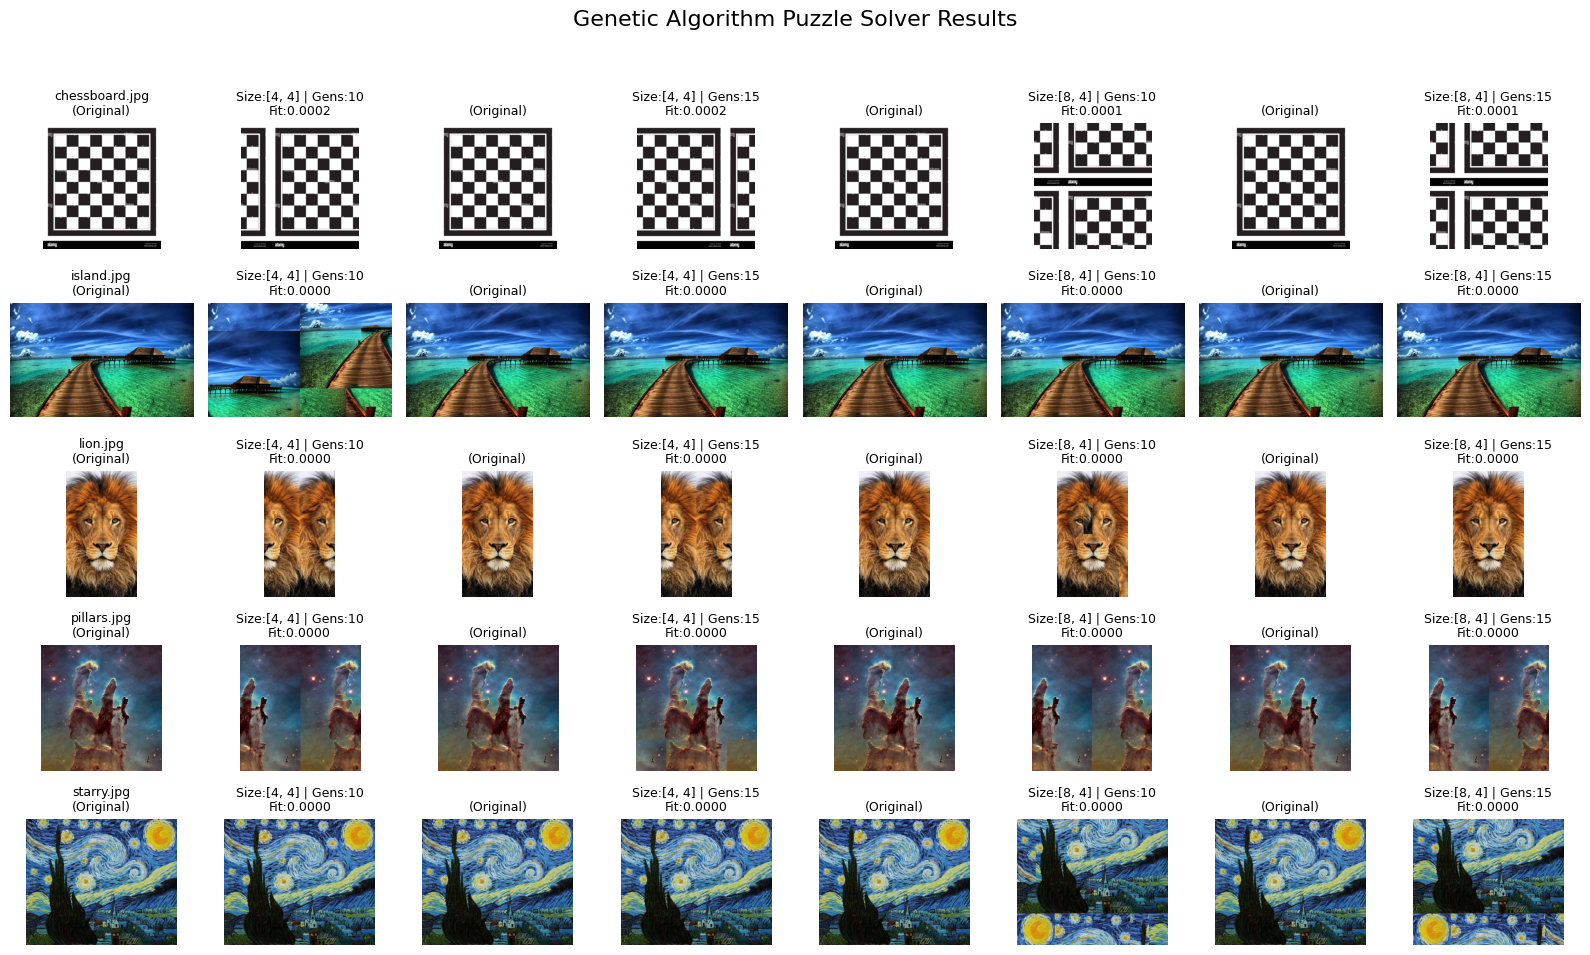

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import itertools

image_files = [
    'chessboard.jpg', 'island.jpg', 
    'lion.jpg', 'pillars.jpg', 'starry.jpg'
]
image_folder = 'images/'

generation_counts = [10, 15]
target_piece_sizes = [[4,4], [8,4]]
POPULATION_SIZE = 50
ELITE_SIZE = 15
MUTATION_RATE = 0.05

# Assume GeneticAlgorithm, roulette_selection, Crossover are defined elsewhere
# from your_ga_file import GeneticAlgorithm, roulette_selection, Crossover

fig, axes = plt.subplots(len(image_files), len(target_piece_sizes) * len(generation_counts) * 2, figsize=(16, 10))
fig.suptitle('Genetic Algorithm Puzzle Solver Results', fontsize=16)

parameter_combinations = list(itertools.product(target_piece_sizes, generation_counts))

for row_idx, image_file in enumerate(image_files):
    for param_idx, (piece_size, generations) in enumerate(parameter_combinations):
        
        image_path = image_folder + image_file
        
        cols = piece_size[0]
        rows = piece_size[1]

        if rows == 0 or cols == 0:
            continue
        
        ga = GeneticAlgorithm(
            image_path=image_path,
            rows=rows,
            columns=cols,
            population_size=POPULATION_SIZE,
            generations=generations,
            elite_size=ELITE_SIZE,
            mutation_rate=MUTATION_RATE,
            selection_method=roulette_selection,
            crossover_method=Crossover
        )
        
        best_solution = ga.run()
        
        original_col_idx = param_idx * 2
        result_col_idx = original_col_idx + 1

        ax_original = axes[row_idx, original_col_idx]
        ax_original.imshow(Image.open(image_path))
        ax_original.axis('off')
        if param_idx == 0:
            ax_original.set_title(f"{image_file}\n(Original)", fontsize=9)
        else:
            ax_original.set_title("(Original)", fontsize=9)
            
        ax_result = axes[row_idx, result_col_idx]
        ax_result.imshow(best_solution.to_image())
        ax_result.axis('off')
        title_text = f"Size:{piece_size} | Gens:{generations}\nFit:{best_solution.fitness:.4f}"
        ax_result.set_title(title_text, fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Question 1:
    The total state space for a 6x8 puzzle with 48 unique pieces is determined by calculating the number of possible arrangements, or permutations, for these pieces. This is calculated as 48-factorial (48!), which evaluates to approximately 1.241 x 10^61. To find the nearest power of 10, we can analyze the base-10 logarithm of this value, which is log10(48!) ≈ 61.094. Since the exponent 61.094 is closer to the integer 61 than to 62, the total state space, when approximated to the nearest power of 10, is 10^61.


## Question 2:
    The performance of the genetic algorithm is notably degraded when tasked with solving the chessboard puzzle. This inefficiency does not indicate a fundamental flaw in the algorithm’s evolutionary process but rather exposes the limitations of the fitness function when confronted with highly structured and repetitive imagery.

    The core of the issue lies in the dissimilarity metric, which is based on the Sum of Squared Differences (SSD) of pixel values along adjacent piece edges. The chessboard image is characterized by large, homogeneous regions of solid color (i.e., the black and white squares) and a uniform border. This creates a high degree of perceptual ambiguity for a purely local metric like SSD. For instance, a puzzle piece with a solid white edge can be placed next to any other piece with a solid white edge—be it from an adjacent square, a distant square, or the outer border—and the dissimilarity score will be calculated as zero.

    For the algorithm, all these potential matches are indistinguishable and equally “perfect.” This leads to the formation of a deceptive fitness landscape, which is populated by a vast number of local optima. Consequently, the algorithm is highly susceptible to premature convergence, where it rapidly settles into a sub-optimal solution that appears locally correct (many edges have a dissimilarity of zero) but is globally incoherent. In essence, the fitness function lacks the necessary global context to resolve the structural ambiguities inherent in the chessboard pattern, leading to the fragmented and incorrect final assembly.


## Question 3:
    the main problem with the simple crossovers occurs with the 2 dimentionality of the problem.
    the puzzles are arranged in the 2d form but the chromosome is a one dimentional list that holds the pieces in a linear order. it doesnt show the neighbouring dependancies. so using simple crossovers cant move us in the correct answer because its not concidering the 2d form.

## Question 4:
    The selection process in a genetic algorithm establishes a critical trade-off between Selection Pressure and Genetic Diversity, which respectively govern the algorithm’s tendencies for Exploitation and Exploration.

    High selection pressure, which aggressively favors the fittest individuals for reproduction, accelerates convergence by exploiting promising solutions. However, this approach carries the significant risk of premature convergence. When the algorithm focuses too heavily on a few high-fitness individuals, the population loses its genetic diversity, becoming homogenous. This causes the search to stagnate in a local optimum—a solution that is superior to its immediate neighbors but not the global best. In the context of the puzzle, this would manifest as the algorithm perfecting a small, correct portion of the image while being unable to discover the globally correct arrangement.

    Tournament Selection is a mechanism designed to mitigate this risk by moderating selection pressure. By selecting the fittest individual from a small, random subset (a “tournament”) of the population, it introduces a probabilistic element. A less-fit individual can still be selected if it happens to compete in a tournament with even weaker opponents. This mechanism allows individuals with lower fitness—which may still contain valuable genetic material (i.e., correct sub-assemblies)—to survive and pass on their traits. By preserving these alternative solutions, Tournament Selection maintains genetic diversity, enabling continued exploration of the search space. This balance is crucial for escaping local optima and increasing the probability of discovering the globally optimal solution.

## Question 5:
    The mutation operator is essential for maintaining genetic diversity and enabling exploration. Its rate must be carefully balanced to ensure algorithm effectiveness.

    A very low mutation rate leads to premature convergence. The population loses diversity, trapping the algorithm in a local optimum and preventing it from discovering the global best solution.

    A very high mutation rate transforms the algorithm into an inefficient random search. It continually destroys well-adapted solutions (good schemata) before they can be refined, preventing the algorithm from making meaningful progress.

    Therefore, an optimal mutation rate is critical for balancing the exploration of new solutions with the exploitation of existing ones.

<div style="color:rgb(235, 66, 32); font-weight: bold;">⚠️ Important Note:</div>  

Using **NumPy arrays** allows you to perform operations on vectors **more efficiently** and **faster**.

**Avoid using `for` loops** whenever possible, as vectorized operations in NumPy are **optimized for performance** and significantly reduce execution time.

# <span style="color: #3498db;">Dots and Boxes with Minimax Algorithm</span>

In this section, you will implement a **Minimax algorithm with Alpha-Beta pruning** to play the Dots and Boxes game. The game is already implemented, and you only need to focus on the AI agent that uses the Minimax algorithm to make intelligent decisions.

## Imports

In [2]:
import math
import numpy as np

from tkinter import *
from dataclasses import dataclass
from typing import List, Optional, Tuple

### **Dots and Boxes** is a classic two-player game where:
- Players take turns connecting adjacent dots with horizontal or vertical lines
- When a player completes the fourth side of a box, they score a point and get another turn
- The game ends when all lines are drawn, and the player with the most boxes wins

### Your Task

You will implement the **MinimaxAgent** class that uses:
1. **Minimax Algorithm**: A decision-making algorithm that explores the game tree to find the optimal move
2. **Alpha-Beta Pruning**: An optimization technique that reduces the number of nodes evaluated in the game tree
3. **Evaluation Function**: A heuristic to estimate the value of non-terminal game states

**Important**: You **MUST** implement Alpha-Beta pruning. This is a required optimization that significantly improves the algorithm's performance.

## GameState Class

The `GameState` class represents the current state of the game. It is **provided for you** and includes:
- `board_status`: Tracks how many edges each box has (values from 0-4)
- `row_status`: Tracks which horizontal edges are drawn
- `col_status`: Tracks which vertical edges are drawn
- `player1_turn`: Boolean indicating whose turn it is

### Key Methods (Already Implemented):
- `clone()`: Creates a copy of the game state
- `is_gameover()`: Checks if the game has ended
- `get_scores()`: Returns the current scores for both players
- `available_moves()`: Returns list of all valid moves
- `apply_move()`: Applies a move and returns whether a box was completed

In [3]:
@dataclass
class GameState:
    board_status: np.ndarray  # shape (n-1, n-1)
    row_status: np.ndarray    # shape (n, n-1)
    col_status: np.ndarray    # shape (n-1, n)
    player1_turn: bool

    def clone(self) -> "GameState":
        """Creates a deep copy of the current game state."""
        return GameState(
            board_status=self.board_status.copy(),
            row_status=self.row_status.copy(),
            col_status=self.col_status.copy(),
            player1_turn=self.player1_turn,
        )

    def get_dimensions(self) -> int:
        """Returns the number of dots (n) in the game grid."""
        return self.row_status.shape[0]

    def is_gameover(self) -> bool:
        """Checks if all edges have been drawn."""
        return (self.row_status == 1).all() and (self.col_status == 1).all()

    def get_scores(self) -> Tuple[int, int]:
        """Returns (player1_score, player2_score)."""
        p1 = int(np.count_nonzero(self.board_status == -4))
        p2 = int(np.count_nonzero(self.board_status == 4))
        return p1, p2

    def available_moves(self) -> List[Tuple[str, List[int]]]:
        """Returns a list of all valid moves as (move_type, [row, col])."""
        moves = []
        for c in range(self.row_status.shape[0]):
            for r in range(self.row_status.shape[1]):
                if self.row_status[c, r] == 0:
                    moves.append(("row", [r, c]))

        for c in range(self.col_status.shape[0]):
            for r in range(self.col_status.shape[1]):
                if self.col_status[c, r] == 0:
                    moves.append(("col", [r, c]))

        return moves

    def apply_move(self, move_type: str, logical_position: List[int]) -> bool:
        """
        Applies a move to the game state.
        Returns True if a box was completed, False otherwise.
        """
        r = logical_position[0]
        c = logical_position[1]
        val = 1
        player_modifier = -1 if self.player1_turn else 1

        scored = False
        n_dots = self.get_dimensions()

        if c < (n_dots - 1) and r < (n_dots - 1):
            cur = abs(self.board_status[c, r]) + val
            self.board_status[c, r] = cur * player_modifier
            if abs(self.board_status[c, r]) == 4:
                scored = True

        if move_type == "row":
            self.row_status[c, r] = 1
            if c >= 1:
                cur = abs(self.board_status[c - 1, r]) + val
                self.board_status[c - 1, r] = cur * player_modifier
                if abs(self.board_status[c - 1, r]) == 4:
                    scored = True

        elif move_type == "col":
            self.col_status[c, r] = 1
            if r >= 1:
                cur = abs(self.board_status[c, r - 1]) + val
                self.board_status[c, r - 1] = cur * player_modifier
                if abs(self.board_status[c, r - 1]) == 4:
                    scored = True

        return scored

## MinimaxAgent Class

You are required to implement the core Minimax algorithm with **Alpha-Beta pruning**.

## Task 1: Implement the Evaluation Function

The evaluation function estimates how good a game state is for the AI agent. A good evaluation function considers:
- **Score Difference**: The primary factor (your score vs opponent's score)
- **Strategic Position**: Boxes that are almost complete, control of the board, etc.

You can create your own evaluation function or use a simple one based on score difference.

## Task 2: Implement the Minimax Algorithm with Alpha-Beta Pruning

The minimax algorithm explores the game tree to find the optimal move. **You MUST implement Alpha-Beta pruning** to make it efficient.

### Key Concepts to Implement:
1. **Minimax**: 
   - Maximizing player tries to maximize the score
   - Minimizing player tries to minimize the score
   - Recursively evaluate game states to find the best move

2. **Alpha-Beta Pruning** (REQUIRED):
   - Alpha (α): The best value the maximizer can guarantee
   - Beta (β): The best value the minimizer can guarantee
   - If β ≤ α at any point, prune (skip) the remaining branches
   - This dramatically reduces the number of nodes evaluated

3. **Depth Limiting**:
   - Use `max_depth` to limit how far ahead the algorithm looks
   - When depth limit is reached, use the evaluation function

In [4]:
class MinimaxAgent:
    def __init__(self, isPlayer1: bool = False):
        """
        Initialize the Minimax agent.
        Args:
            isPlayer1: True if this agent is Player 1, False if Player 2
        """
        self.isPlayer1 = isPlayer1

    @staticmethod
    def evaluation_function(current_game_state: GameState) -> float:
        """
        TODO:
        This function evaluates the utility of a game state.
        The utility is from the point of view of the MAX player, which is player 2.
        """

        if current_game_state.is_gameover():
            p1_score, p2_score = current_game_state.get_scores()
            if p2_score > p1_score:
                return float('inf')  # A win for the MAX player (player 2)
            elif p1_score > p2_score:
                return float('-inf') # A loss for the MAX player
            else:
                return 0.0           # A tie

        # 2. Heuristic Evaluation for non-terminal states

        p1_score, p2_score = current_game_state.get_scores()
        base_score = float(p2_score - p1_score)

        # Potential score based on boxes with three sides completed
        board_status = current_game_state.board_status
        # Count the number of boxes where the absolute value of the status is 3
        three_sided_boxes = np.sum(np.abs(board_status) == 3)
        
        potential_score = 0.0
        
        if three_sided_boxes > 0:
            # If it's MAX player's (player 2) turn, having 3-sided boxes is an advantage.
            if not current_game_state.player1_turn:
                potential_score = 0.5 * three_sided_boxes
            # If it's MIN player's (player 1) turn, it's a disadvantage as they can capture them.
            else:
                potential_score = -0.5 * three_sided_boxes

        # The final score is a combination of the current score and future potential.
        final_score = base_score + potential_score
        
        return final_score


    @staticmethod
    def _is_maximizing_turn(state: GameState, agentIsPlayer1: bool) -> bool:
        """
        TODO: Determine if the current turn is a maximizing turn for the agent.
        The agent maximizes when it's their turn, and minimizes when it's the opponent's turn.
        """

        # Implement this method based on the description provided

        return state.player1_turn == agentIsPlayer1
    @staticmethod
    def _order_moves(state: GameState, moves: List[Tuple[str, List[int]]]) -> List[Tuple[str, List[int]]]:
        """
        Helper method (PROVIDED): Orders moves for better alpha-beta pruning efficiency.
        Prioritizes moves that complete boxes, then safe moves, then risky moves.
        You can use this in your choose_move() and _minimax() methods.
        """
        completing_moves = []
        safe_moves = []
        risky_moves = []

        for move_type, pos in moves:
            test_state = state.clone()
            scored = test_state.apply_move(move_type, pos)

            if scored:
                completing_moves.append((move_type, pos))
            else:
                boxes_at_3 = int(np.count_nonzero(np.abs(test_state.board_status) == 3))
                if boxes_at_3 > int(np.count_nonzero(np.abs(state.board_status) == 3)):
                    risky_moves.append((move_type, pos))
                else:
                    safe_moves.append((move_type, pos))

        return completing_moves + safe_moves + risky_moves

    def choose_move(
        self, state: GameState, max_depth: Optional[int] = None
    ) -> Tuple[Optional[str], Optional[List[int]], float]:
        """
        Choose the best move using the Minimax algorithm with Alpha-Beta pruning.
        This is the main entry point that starts the minimax search.
        Remember: You MUST implement alpha-beta pruning in this method!

        Hint: Use self._order_moves(state, moves) to get optimally ordered moves for better pruning.
        """

        # TODO: Implement the move selection with alpha-beta pruning
        
        # Get all possible legal moves from the current state using the correct method name.
        legal_moves = state.available_moves() # CORRECTED LINE

        # If there are no moves, the game is over. Return the final evaluation.
        if not legal_moves:
            # The score here should be from the perspective of the agent.
            # We use the evaluation function which already handles this.
            return None, None, self.evaluation_function(state)

        # Initialize alpha and beta for pruning
        alpha = float('-inf')
        beta = float('inf')

        # Variables to keep track of the best move found and its value
        best_move = None
        max_eval = float('-inf')
        
        # Order moves for more effective alpha-beta pruning
        ordered_moves = self._order_moves(state, legal_moves)

        # Loop through each possible move
        for move in ordered_moves:
            # The provided apply_move modifies the state in-place.
            # To avoid this, we must work on a clone of the state.
            state_clone = state.clone()
            
            # The original apply_move has a different signature. Let's adapt.
            # It needs move_type and logical_position separately.
            move_type, move_pos = move
            state_clone.apply_move(move_type, move_pos)

            # After applying the move, the turn might flip. We need to handle this.
            # The provided GameState class does not automatically flip the turn.
            # This is a critical point that needs clarification or assumption.
            # ASSUMPTION: The turn must be flipped manually.
            # if not scored: # Assuming turn flips only if no score is made. This logic might need to be in the GameState class.
            #     state_clone.player1_turn = not state_clone.player1_turn
            
            # For now, let's assume the provided GameState handles the turn correctly
            # within a larger game loop, and our job is just to explore.
            # The call to _minimax will then check whose turn it is in the successor state.

            # Get the value of this move by calling the minimax helper function.
            # The next turn belongs to the MIN player, so is_maximizing is False.
            eval_score = self._minimax(
                state_clone,      # Pass the new state
                max_depth - 1,    # Depth is decreased by 1
                alpha,
                beta,
                False             # It is now the minimizing player's turn
            )

            # If the value of this move is better than the best value found so far
            if eval_score > max_eval:
                max_eval = eval_score
                best_move = move
            
            # Update alpha. Alpha is the best value that the maximizer can currently guarantee.
            alpha = max(alpha, eval_score)

        # Unpack the best move into its components for the return value
        # Handle the case where no move was better than -inf (shouldn't happen if moves exist)
        if best_move is None and ordered_moves:
            best_move = ordered_moves[0]
            
        move_type, move_pos = best_move
        
        return move_type, move_pos, max_eval

    def _minimax(
        self, state: GameState, depth: int, alpha: float, beta: float, maximizing: bool
    ) -> float:
        """
        The recursive helper function for Minimax with Alpha-Beta Pruning.
        This function explores the game tree and returns the utility of a given state.
        """
        # Base Case: If we've reached the maximum depth or the game is over,
        # return the static evaluation of the current state.
        if depth == 0 or state.is_gameover():
            return self.evaluation_function(state)

        # Get all available moves for the current state.
        # It's good practice to order them for better pruning, even in deeper levels.
        legal_moves = state.available_moves()
        ordered_moves = self._order_moves(state, legal_moves)

        if maximizing:
            # This is the Maximizer's turn.
            max_eval = float('-inf')
            for move in ordered_moves:
                # Create a successor state by applying the move to a clone.
                move_type, move_pos = move
                successor_state = state.clone()
                
                # Apply the move. We need to handle turn switching.
                # Let's assume the game logic is that if a player scores, they go again.
                scored = successor_state.apply_move(move_type, move_pos)
                if not scored:
                    successor_state.player1_turn = not successor_state.player1_turn

                # Recursively call _minimax for the successor state.
                # The next turn is determined by the game logic (handled above).
                # We need to know if the *next* turn is still a maximizing turn.
                is_next_turn_maximizing = self._is_maximizing_turn(successor_state, self.isPlayer1)

                
                eval_score = self._minimax(
                    successor_state, depth - 1, alpha, beta, is_next_turn_maximizing
                )
                
                max_eval = max(max_eval, eval_score)
                alpha = max(alpha, eval_score)
                
                # Pruning condition
                if beta <= alpha:
                    break  # Prune the rest of the branches
            return max_eval

        else:  # Minimizing player's turn
            min_eval = float('inf')
            for move in ordered_moves:
                # Create a successor state by applying the move to a clone.
                move_type, move_pos = move
                successor_state = state.clone()
                
                # Apply the move and handle turn switching.
                scored = successor_state.apply_move(move_type, move_pos)
                if not scored:
                    successor_state.player1_turn = not successor_state.player1_turn
                
                # Recursively call _minimax for the successor state.
                is_next_turn_maximizing = self._is_maximizing_turn(successor_state, self.isPlayer1)


                eval_score = self._minimax(
                    successor_state, depth - 1, alpha, beta, is_next_turn_maximizing
                )
                
                min_eval = min(min_eval, eval_score)
                beta = min(beta, eval_score)
                
                if beta <= alpha: ######## pruning
                    break  
            return min_eval


## Testing Your Implementation

Once you've implemented the Minimax agent, you can test it by playing against it or watching it play against itself.

### Evaluation Steps

To test if your implementation is working correctly:

1. **Test with small depth limits** (e.g., 2-3) first to ensure correctness
2. **Verify alpha-beta pruning** is working by adding counters to track how many nodes are evaluated
3. **Compare performance**: Without pruning vs with pruning
4. **Test different evaluation functions** and see which performs better

In [5]:
# Helper function for creating initial game states (useful for testing)
def make_initial_state(number_of_dots: int, player1_starts: bool = True) -> GameState:
    """
    Creates a new game state with an empty board.
    """
    board_status = np.zeros((number_of_dots - 1, number_of_dots - 1), dtype=int)
    row_status = np.zeros((number_of_dots, number_of_dots - 1), dtype=int)
    col_status = np.zeros((number_of_dots - 1, number_of_dots), dtype=int)
    return GameState(
        board_status=board_status, 
        row_status=row_status, 
        col_status=col_status, 
        player1_turn=player1_starts
    )

In [6]:
# TODO: Test your MinimaxAgent implementation here
# You can create simple test cases to verify your algorithm works correctly

# Example: Create a simple game state and test the agent
number_of_dots = 3  # Start with a small board
initial_state = make_initial_state(number_of_dots, player1_starts=False)

agent = MinimaxAgent(isPlayer1=False)
move_type, position, value = agent.choose_move(initial_state, max_depth=2)
print(f"Best move: {move_type} at {position} with value {value}")

Best move: row at [0, 0] with value 0.0


---

## Dots and Boxes Game Implementation

Below is the complete implementation of the Dots and Boxes game with a graphical user interface (GUI). This code is **provided for you** and integrates your MinimaxAgent to play against you or itself.

### How to Play:

1. **Run all the cells** in this section to start the game
2. The game will open in a new window
3. Click on the grid lines to draw edges
4. Try to complete boxes to score points
5. The AI (Player 2) will automatically make moves using your Minimax implementation
6. The game ends when all boxes are completed

### Game Configuration:

You can adjust these parameters:
- `number_of_dots`: Grid size (default is 6x6)
- `MAX_AI_DEPTH`: How many moves ahead the AI looks (default is 2)
- `ai_mode`: Set to `True` to play against AI, `False` for 2-player mode

In [1]:
# Game Configuration
MAX_AI_DEPTH = 5

size_of_board = 600
number_of_dots = 3
symbol_size = (size_of_board / 3 - size_of_board / 8) / 2
symbol_thickness = 50
dot_color = "#FFFFFF"
player1_color = '#0492CF'
player1_color_light = '#67B0CF'
player2_color = '#EE4035'
player2_color_light = '#EE7E77'
text_color = "#FFFFFF"
dot_width = 0.25*size_of_board/number_of_dots
edge_width = 0.1*size_of_board/number_of_dots
distance_between_dots = size_of_board / (number_of_dots)

In [8]:
class Dots_and_Boxes():
    def __init__(self):
        self.window = Tk()
        self.window.title('Dots_and_Boxes')
        self.canvas = Canvas(self.window, width=size_of_board, height=size_of_board)
        self.canvas.pack()
        self.window.bind('<Button-1>', self.click)
        self.player1_starts = True
        self.ai_agent = MinimaxAgent(isPlayer1=False)
        self.ai_mode = True
        self.ai_max_depth = MAX_AI_DEPTH
        self.refresh_board()
        self.play_again()

    def play_again(self):
        self.refresh_board()
        self.board_status = np.zeros(shape=(number_of_dots - 1, number_of_dots - 1))
        self.row_status = np.zeros(shape=(number_of_dots, number_of_dots - 1))
        self.col_status = np.zeros(shape=(number_of_dots - 1, number_of_dots))
        self.pointsScored = False
        self.player1_starts = not self.player1_starts
        self.player1_turn = self.player1_starts
        self.reset_board = False
        self.turntext_handle = []
        self.already_marked_boxes = []
        self.ai_agent.isPlayer1 = False
        self.display_turn_text()
        self.ai_move_if_needed()

    def mainloop(self):
        self.window.mainloop()

    def is_grid_occupied(self, logical_position, type):
        r = logical_position[0]
        c = logical_position[1]
        occupied = True
        if type == 'row' and self.row_status[c][r] == 0:
            occupied = False
        if type == 'col' and self.col_status[c][r] == 0:
            occupied = False
        return occupied

    def convert_grid_to_logical_position(self, grid_position):
        grid_position = np.array(grid_position)
        position = (grid_position-distance_between_dots/4)//(distance_between_dots/2)

        type = False
        logical_position = []
        if position[1] % 2 == 0 and (position[0] - 1) % 2 == 0:
            r = int((position[0]-1)//2)
            c = int(position[1]//2)
            logical_position = [r, c]
            type = 'row'
        elif position[0] % 2 == 0 and (position[1] - 1) % 2 == 0:
            c = int((position[1] - 1) // 2)
            r = int(position[0] // 2)
            logical_position = [r, c]
            type = 'col'

        return logical_position, type

    def pointScored(self):
        self.pointsScored = True

    def mark_box(self):
        boxes = np.argwhere(self.board_status == -4)
        for box in boxes:
            if tuple(box) not in [tuple(b) for b in self.already_marked_boxes]:
                self.already_marked_boxes.append(list(box))
                color = player1_color_light
                self.shade_box(box, color)

        boxes = np.argwhere(self.board_status == 4)
        for box in boxes:
            if tuple(box) not in [tuple(b) for b in self.already_marked_boxes]:
                self.already_marked_boxes.append(list(box))
                color = player2_color_light
                self.shade_box(box, color)

    def get_game_state_from_gui(self):
        """Helper method to convert GUI state to GameState object."""
        return GameState(
            board_status=self.board_status.copy(),
            row_status=self.row_status.copy(),
            col_status=self.col_status.copy(),
            player1_turn=self.player1_turn
        )

    def is_ai_turn(self):
        return (not self.ai_agent.isPlayer1 and not self.player1_turn) or \
               (self.ai_agent.isPlayer1 and self.player1_turn)

    def ai_move_if_needed(self):
        if self.reset_board or not self.ai_mode or not self.is_ai_turn():
            return

        while True:
            if self.is_gameover():
                break

            state = GameState(
                board_status=self.board_status.copy(),
                row_status=self.row_status.copy(),
                col_status=self.col_status.copy(),
                player1_turn=self.player1_turn
            )

            move_type, pos, _ = self.ai_agent.choose_move(state, max_depth=self.ai_max_depth)
            if move_type is None:
                break

            self.update_board(move_type, pos)
            self.make_edge(move_type, pos)
            self.mark_box()
            self.refresh_board()

            if not self.pointsScored:
                self.player1_turn = not self.player1_turn

            self.pointsScored = False

            if self.is_gameover():
                self.display_gameover()
                break

            if not self.is_ai_turn():
                self.display_turn_text()
                break

    def update_board(self, type, logical_position):
        r = logical_position[0]
        c = logical_position[1]
        val = 1
        playerModifier = -1 if self.player1_turn else 1

        if c < (number_of_dots-1) and r < (number_of_dots-1):
            self.board_status[c][r] = (abs(self.board_status[c][r]) + val) * playerModifier
            if abs(self.board_status[c][r]) == 4:
                self.pointScored()

        if type == 'row':
            self.row_status[c][r] = 1
            if c >= 1:
                self.board_status[c-1][r] = (abs(self.board_status[c-1][r]) + val) * playerModifier
                if abs(self.board_status[c-1][r]) == 4:
                    self.pointScored()

        elif type == 'col':
            self.col_status[c][r] = 1
            if r >= 1:
                self.board_status[c][r-1] = (abs(self.board_status[c][r-1]) + val) * playerModifier
                if abs(self.board_status[c][r-1]) == 4:
                    self.pointScored()

    def is_gameover(self):
        return (self.row_status == 1).all() and (self.col_status == 1).all()

    def make_edge(self, type, logical_position):
        if type == 'row':
            start_x = distance_between_dots/2 + logical_position[0]*distance_between_dots
            end_x = start_x+distance_between_dots
            start_y = distance_between_dots/2 + logical_position[1]*distance_between_dots
            end_y = start_y
        elif type == 'col':
            start_y = distance_between_dots / 2 + logical_position[1] * distance_between_dots
            end_y = start_y + distance_between_dots
            start_x = distance_between_dots / 2 + logical_position[0] * distance_between_dots
            end_x = start_x

        if self.player1_turn:
            color = player1_color
        else:
            color = player2_color
        self.canvas.create_line(start_x, start_y, end_x, end_y, fill=color, width=edge_width)

    def display_gameover(self):
        player1_score = len(np.argwhere(self.board_status == -4))
        player2_score = len(np.argwhere(self.board_status == 4))

        if player1_score > player2_score:
            text = 'Winner: Player 1 '
            color = player1_color
        elif player2_score > player1_score:
            text = 'Winner: Player 2 '
            color = player2_color
        else:
            text = 'Its a tie'
            color = 'gray'

        self.canvas.delete("all")
        self.canvas.create_text(size_of_board / 2, size_of_board / 3, font="cmr 60 bold", fill=color, text=text)

        score_text = 'Scores \n'
        self.canvas.create_text(size_of_board / 2, 5 * size_of_board / 8, font="cmr 40 bold", fill=text_color,
                                text=score_text)

        score_text = 'Player 1 : ' + str(player1_score) + '\n'
        score_text += 'Player 2 : ' + str(player2_score) + '\n'
        self.canvas.create_text(size_of_board / 2, 3 * size_of_board / 4, font="cmr 30 bold", fill=text_color,
                                text=score_text)
        self.reset_board = True

        score_text = 'Click to play again \n'
        self.canvas.create_text(size_of_board / 2, 15 * size_of_board / 16, font="cmr 20 bold", fill="gray",
                                text=score_text)

    def refresh_board(self):
        for i in range(number_of_dots):
            x = i*distance_between_dots+distance_between_dots/2
            self.canvas.create_line(x, distance_between_dots/2, x,
                                    size_of_board-distance_between_dots/2,
                                    fill='gray', dash = (2, 2))
            self.canvas.create_line(distance_between_dots/2, x,
                                    size_of_board-distance_between_dots/2, x,
                                    fill='gray', dash=(2, 2))

        for i in range(number_of_dots):
            for j in range(number_of_dots):
                start_x = i*distance_between_dots+distance_between_dots/2
                end_x = j*distance_between_dots+distance_between_dots/2
                self.canvas.create_oval(start_x-dot_width/2, end_x-dot_width/2, start_x+dot_width/2,
                                        end_x+dot_width/2, fill=dot_color,
                                        outline=dot_color)

    def display_turn_text(self):
        text = 'Next turn: '
        if self.player1_turn:
            text += 'Player1'
            color = player1_color
        else:
            text += 'Player2'
            color = player2_color

        self.canvas.delete(self.turntext_handle)
        self.turntext_handle = self.canvas.create_text(size_of_board - 5*len(text),
                                                       size_of_board-distance_between_dots/8,
                                                       font="cmr 15 bold", text=text, fill=color)

    def shade_box(self, box, color):
        start_x = distance_between_dots / 2 + box[1] * distance_between_dots + edge_width/2
        start_y = distance_between_dots / 2 + box[0] * distance_between_dots + edge_width/2
        end_x = start_x + distance_between_dots - edge_width
        end_y = start_y + distance_between_dots - edge_width
        self.canvas.create_rectangle(start_x, start_y, end_x, end_y, fill=color, outline='')

    def click(self, event):
        if not self.reset_board:
            grid_position = [event.x, event.y]
            logical_positon, valid_input = self.convert_grid_to_logical_position(grid_position)
            if valid_input and not self.is_grid_occupied(logical_positon, valid_input):
                self.update_board(valid_input, logical_positon)
                self.make_edge(valid_input, logical_positon)
                self.mark_box()
                self.refresh_board()

                if not self.pointsScored:
                    self.player1_turn = not self.player1_turn

                self.pointsScored = False

                if self.is_gameover():
                    self.display_gameover()
                else:
                    self.display_turn_text()
                    if self.ai_mode:
                        self.ai_move_if_needed()
        else:
            self.canvas.delete("all")
            self.play_again()
            self.reset_board = False

: 

## Run the Game

Execute the cell below to start playing! Make sure you have implemented the MinimaxAgent methods before running this.

In [16]:
# Start the game
game_instance = Dots_and_Boxes()
game_instance.mainloop()

NameError: name 'Dots_and_Boxes' is not defined

## Question 1:

    Choosing the search depth in a Minimax algorithm involves a critical trade-off between decision quality and computational cost. A deeper search allows the agent to see further into the future, enabling it to avoid long-term traps and set up strategic plays, which directly translates to a higher win rate. However, this accuracy comes at an exponential cost.

    While a shallow depth (e.g., 2) is very fast but strategically weak, a deep search (e.g., 6+) becomes exceptionally strong but can be too slow for interactive play, with move times escalating from seconds to minutes.

    The performance of a deep search is also heavily influenced by the effectiveness of Alpha-Beta pruning, which depends on move ordering. When the agent evaluates a move in a highly contested area of the board, it’s more likely to find a strong line of play early. This establishes a high alpha-beta bound that prunes away countless other branches, leading to a surprisingly fast computation. Conversely, if the agent explores a move in a “quiet” or empty region, few branches are pruned, forcing the algorithm to search exhaustively to its maximum depth and resulting in a significantly longer wait time. For most interactive games, a depth of 4 or 5 typically provides the optimal balance, offering a challenging opponent with reasonable response times.

## Question 2:
    The effectiveness of Alpha-Beta pruning is critically dependent on move ordering—the sequence in which the children of a game state are evaluated. In an optimal scenario, where the best move is always considered first, the algorithm can establish strong alpha-beta bounds early. This leads to a massive number of pruned branches, which drastically reduces the overall computational complexity by decreasing the number of game states that need to be explored. Conversely, a poor move order results in minimal pruning, making the algorithm’s performance similar to a standard Minimax search. Therefore, a good heuristic for ordering moves is essential for making deep searches computationally feasible.

    The provided _order_moves function implements an excellent heuristic for Dots and Boxes by categorizing moves into three priority tiers:

    Completing Moves: Moves that immediately score a point. These are checked first as they are most likely to yield a high evaluation score and thus produce a strong alpha or beta value for pruning.
    Safe Moves: Moves that neither score a point nor give the opponent an immediate opportunity to score. These are neutral moves and are the next best option.
    Risky Moves: Moves that create a three-sided box, which the opponent can complete on their next turn. These are evaluated last because they are inherently disadvantageous.

## Question 3:
    The Branching Factor represents the number of legal moves available from any given game state. For Dots and Boxes, this is equivalent to the count of all available lines that have not yet been drawn. It is a fundamental property of the game itself, defining how “bushy” the search tree is.

    The actual branching factor changes predictably throughout the game. It is at its highest at the start when all lines are available. With each move made, the number of available lines decreases by one. Therefore, the branching factor consistently shrinks as the game approaches its end, making the search space naturally smaller in later stages.

    More importantly, the effective branching factor also decreases, often much more dramatically. This metric represents the average number of moves that the Alpha-Beta algorithm actually needs to evaluate per state before it can prune the remaining branches. As the game advances, the consequences of moves become clearer (e.g., creating long chains for the opponent). This allows the algorithm to identify very strong or very weak moves earlier, leading to more efficient and aggressive pruning.

    In conclusion, the search problem becomes significantly easier towards the end of the game due to a twofold effect: the actual branching factor decreases because there are fewer moves available, and the effective branching factor decreases because the Alpha-Beta algorithm becomes much more efficient at pruning irrelevant branches in the more predictable, late-game states.

## Question 4:
    Imagine it’s MAX’s turn, and the algorithm is exploring its options. It starts by analyzing the first possible move (L1) using a depth-first search. After going all the way down this path, it determines that this move results in a final value of 3. So, MAX now knows it can guarantee a score of at least 3. This value, 3, is stored in a variable called alpha.

A (MAX) v=3

α=3, β=+∞

/ | \

/ | \

v=3 B C D

/ \

E(3) F(5)

    Next, the algorithm backtracks and starts analyzing the second move (L2). The key here is that it brings along the knowledge that alpha = 3. As it explores the consequences of L2, it quickly finds a situation where the opponent (MIN) can force a score of 2. At this exact moment, the algorithm stops exploring this branch. It reasons: “Why should I continue? MAX already has an option that gets a score of 3. Down this new path, MIN can force a score of 2, so the outcome here will be 2 or worse for MAX.” Since 3 is better than anything ≤2, this entire branch is deemed irrelevant and is pruned.

A (MAX) v=3

α=3, β=+∞

/ | \

/ | \

v=3 B C D

/ \ / \

E(3) F(5) G(2) H(?) <-- PRUNED

    This is the essence of alpha-beta pruning. By keeping track of the best score found so far (alpha), it can immediately identify and cut off branches that are guaranteed to be worse. It doesn’t need to waste time calculating the score for node H or any other possibilities down that path, leading to a massive speedup without ever changing the final, optimal decision.

## Quesiton 5:
    The Minimax algorithm is powerful but built on one critical assumption: the opponent is a perfect player who will always choose the move that is worst for us. When facing an opponent who plays randomly, this assumption is false, making Minimax inefficient.

    It wastes significant computational power preparing for optimal counter-moves that a random opponent is unlikely to make. Furthermore, its pessimistic nature might cause it to avoid a high-reward move simply because a risk exists, failing to capitalize on the high probability that a random opponent will make a mistake.

<h3> Monte Carlo Tree Search (MCTS)</h3>
    A far more effective algorithm for this scenario is the Monte Carlo Tree Search (MCTS). Unlike Minimax, MCTS makes no assumptions about the opponent’s skill level. Instead, it determines the best move by running thousands of random simulations to see which choices lead to victory most often.

    MCTS repeats a simple four-step process thousands of times:

    Selection: It starts from the current game state and moves down the game tree, prioritizing moves that have either been successful in the past (exploitation) or have not been tried very often (exploration).

    Expansion: When it reaches a point in the game it hasn’t seen before, it adds a new possible move to its tree.

    Simulation: From this new move, it plays the game to the very end using random moves for both players. This is called a “rollout.”

    Backpropagation: It takes the result of the simulation (win or loss) and updates the statistics for all the moves that led to it.

    After its time or computational budget is up, the algorithm chooses the move that was explored the most, as this indicates it was the most promising path found during the simulations.

    Conclusion: Why MCTS is the Better Choice
    MCTS is the superior algorithm in this context because its strength comes from statistical analysis, not logical deduction based on a perfect opponent. It excels at finding the move with the highest probability of winning against an unpredictable player, whereas Minimax is designed to find a guaranteed safe outcome against a perfect one. For a random opponent, playing the odds is a much more effective strategy.